# L2 – Multilayer perceptron

### PyTorch
1. [Installing PyTorch](https://pytorch.org/get-started/locally/)
2. [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
3. [Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
4. [Useful examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
5. [Mnist example](https://habr.com/company/otus/blog/358096/)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
#from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import train_test_split
import time

from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

ModuleNotFoundError: No module named 'tensorflow'

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset (possible, [this tutorial](https://habr.com/company/otus/blog/358096/) can help you).
4. Chek accuracy on train and validation sets (visualize resulted graph).

$$ p_{i} = \frac{\exp(w_i^{T} x)}{{\sum_j \exp(w^T_jx)}}$$
$$ Q(W) = -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln\left(\frac{\exp(w_i^{T} x)}{{\sum_j \exp(w^T_jx)}}\right) = -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \left( w_i^{T} x - \ln\left({{\sum_j \exp(w^T_jx)}}\right) \right)$$

So we need to count $ \frac{d w_i ^T x}{d w_i} $ and $ \frac{d\ln\left({{\sum_j \exp(w^T_jx)}}\right)} {d w_i} $:

$$ \frac{d w_i ^T x}{d w_i} = x$$
$$\frac{d\ln\left({{\sum_j \exp(w^T_jx)}}\right)} {d w_i} = \frac{1}{{\sum_j \exp(w^T_jx)}}  \cdot \exp({w^T_i x}) \cdot x = p_i \cdot x$$

Finally:

$$ \frac{dQ}{dw_i} = -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot x \cdot (1-p_i)$$

In [2]:
def display_digit(num):
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
x_train = mnist.train.images
print ('x_train Examples Loaded = ' + str(x_train.shape))
y_train = mnist.train.labels
print ('y_train Examples Loaded = ' + str(y_train.shape))
x_test = mnist.test.images
print ('x_test Examples Loaded = ' + str(x_test.shape))
y_test = mnist.test.labels
print ('y_test Examples Loaded = ' + str(y_test.shape))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
x_train Examples Loaded = (55000, 784)
y_train Examples Loaded = (55000, 10)
x_test Examples Loaded = (10000, 784)
y_test Examples Loaded = (10000, 10)


### Some images examples:

Examples number: [ 82 209 321 969 701]


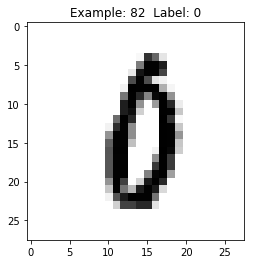

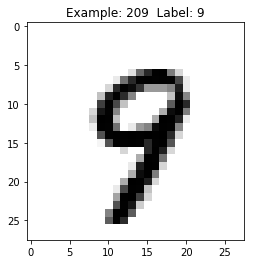

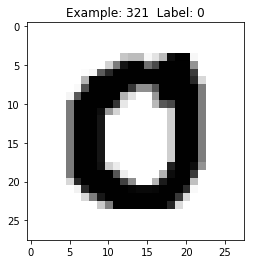

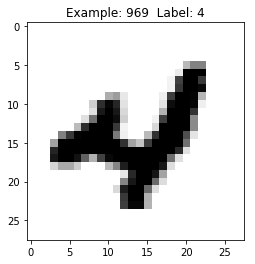

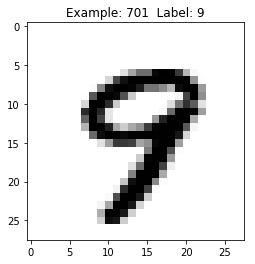

In [4]:
img_examples = np.random.randint(0, 1000, 5)
print("Examples number:", img_examples)
for num in img_examples:
    display_digit(num)

### Let's train our first model:

In [5]:
def generate_batch(x, y, batch_size):
    _, x_batch, _, y_batch = train_test_split(x, y, test_size=batch_size/len(x))
    return x_batch, y_batch

In [6]:
class firstNet(nn.Module):
    def __init__(self):
        super(firstNet, self).__init__()
        self.fc1 = nn.Linear(784, 10) # params - 2D-Tensor 28*28x10
        
    def forward(self, x):
        # x.shape = [50, 1, 28, 28] => [50, 784] => [50, 100] => [50, 10]
        #x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

In [18]:
model = firstNet()
optimizer = optim.SGD(model.parameters(), lr=1)

In [19]:
def train(x_train, y_train, epochs_num, is_print=True):
    data = np.asarray(x_train)
    data = torch.from_numpy(x_train)
    data = data.float()
    
    target = np.asarray(y_train)
    target = torch.from_numpy(target)
    target = target.long()
    for epoch in range(epochs_num):
        optimizer.zero_grad()
        output = model(data)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, torch.max(target, 1)[1])
        loss.backward()
        optimizer.step()
        
        if is_print and epoch % 10 == 0:
            print("Epoch", epoch)
            _, predicted = torch.max(output, 1)
            predicted = predicted.numpy()
            labels = np.argmax(y_train, axis=1)
            is_equal = (predicted == labels)
            print("Train Accuracy = ", 100*np.sum(is_equal)/len(is_equal), "%", sep='')

In [20]:
train(x_train, y_train, 500)

Epoch 0
Train Accuracy = 11.078181818181818%
Epoch 10
Train Accuracy = 55.343636363636364%
Epoch 20
Train Accuracy = 69.82%
Epoch 30
Train Accuracy = 77.38545454545455%
Epoch 40
Train Accuracy = 78.75818181818182%
Epoch 50
Train Accuracy = 79.56545454545454%
Epoch 60
Train Accuracy = 80.1290909090909%
Epoch 70
Train Accuracy = 80.50363636363636%
Epoch 80
Train Accuracy = 80.83272727272727%
Epoch 90
Train Accuracy = 81.10545454545455%
Epoch 100
Train Accuracy = 81.31636363636363%
Epoch 110
Train Accuracy = 81.49272727272728%
Epoch 120
Train Accuracy = 81.66363636363636%
Epoch 130
Train Accuracy = 81.78545454545454%
Epoch 140
Train Accuracy = 81.90181818181819%
Epoch 150
Train Accuracy = 82.02363636363637%
Epoch 160
Train Accuracy = 82.1%
Epoch 170
Train Accuracy = 82.19272727272727%
Epoch 180
Train Accuracy = 82.46%
Epoch 190
Train Accuracy = 84.30727272727273%
Epoch 200
Train Accuracy = 85.69636363636364%
Epoch 210
Train Accuracy = 86.46181818181819%
Epoch 220
Train Accuracy = 87.19454

### Now let's check accuracy on test dataset:

In [21]:
output = model(torch.from_numpy(np.asarray(x_test)).float())
_, predicted = torch.max(output, 1)
predicted = predicted.numpy()
labels = np.argmax(y_test, axis=1)
is_equal = (predicted == labels)
print("Test Accuracy = ", 100*np.sum(is_equal)/len(is_equal), "%", sep='')

Test Accuracy = 90.73%


#### Not so bad!

### It's time to figure out how accuracy depends on epochs number:

In [52]:
epochs = np.arange(5, 200, 5)
train_accuracy = []
test_accuracy = []

for epochs_num in epochs:
    model = firstNet()
    optimizer = optim.SGD(model.parameters(), lr=1)
    
    train(x_train, y_train, epochs_num, False)
    output_test = model(torch.from_numpy(np.asarray(x_test)).float())
    output_train = model(torch.from_numpy(np.asarray(x_train)).float())
    _, predicted_test = torch.max(output_test, 1)
    _, predicted_train = torch.max(output_train, 1)
    predicted_test = predicted_test.numpy()
    predicted_train = predicted_train.numpy()
    labels_test = np.argmax(y_test, axis=1)
    labels_train = np.argmax(y_train, axis=1)
    is_equal_test = (predicted_test == labels_test)
    is_equal_train = (predicted_train == labels_train)
    accuracy_test = 100*np.sum(is_equal_test)/len(is_equal_test)
    accuracy_train = 100*np.sum(is_equal_train)/len(is_equal_train)
    test_accuracy.append(accuracy_test)
    train_accuracy.append(accuracy_train)
    print("Epochs num = ", epochs_num, " finished, ", "progress = ", 100*epochs_num*(epochs_num+5)/(40*41*25), "%", sep='')

Epochs num = 5 finished, progress = 0.12195121951219512%
Epochs num = 10 finished, progress = 0.36585365853658536%
Epochs num = 15 finished, progress = 0.7317073170731707%
Epochs num = 20 finished, progress = 1.2195121951219512%
Epochs num = 25 finished, progress = 1.829268292682927%
Epochs num = 30 finished, progress = 2.5609756097560976%
Epochs num = 35 finished, progress = 3.4146341463414633%
Epochs num = 40 finished, progress = 4.390243902439025%
Epochs num = 45 finished, progress = 5.487804878048781%
Epochs num = 50 finished, progress = 6.7073170731707314%
Epochs num = 55 finished, progress = 8.048780487804878%
Epochs num = 60 finished, progress = 9.512195121951219%
Epochs num = 65 finished, progress = 11.097560975609756%
Epochs num = 70 finished, progress = 12.804878048780488%
Epochs num = 75 finished, progress = 14.634146341463415%
Epochs num = 80 finished, progress = 16.585365853658537%
Epochs num = 85 finished, progress = 18.658536585365855%
Epochs num = 90 finished, progress 

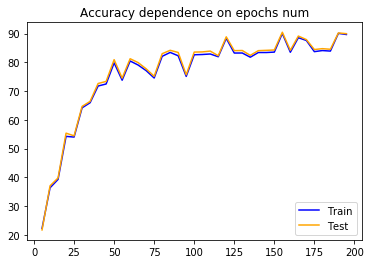

In [58]:
plt.title("Accuracy dependence on epochs num")
plt.plot(epochs, train_accuracy, color='blue')
plt.plot(epochs, test_accuracy, color='orange')
plt.legend(('Train', 'Test'),
           loc='lower right')
plt.show()


Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

In [11]:
class regNet(nn.Module):
    def __init__(self):
        super(regNet, self).__init__()
        self.fc1 = nn.Linear(784, 10) # params - 2D-Tensor 28*28x100
        
    def forward(self, x):
        # x.shape = [50, 1, 28, 28] => [50, 784] => [50, 100] => [50, 10]
        #x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

In [12]:
modelReg = regNet()
optimizer = optim.SGD(modelReg.parameters(), lr=1)

In [15]:
def trainReg(x_train, y_train, epochs_num, lambda1, lambda2, is_print=True):
    data = np.asarray(x_train)
    data = torch.from_numpy(x_train)
    data = data.float()
    
    target = np.asarray(y_train)
    target = torch.from_numpy(target)
    target = target.long()
    for epoch in range(epochs_num):
        optimizer.zero_grad()
        output = modelReg(data)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, torch.max(target, 1)[1])
        
        lossL1 = torch.sum(torch.abs(modelReg.fc1.weight))
        lossL2 = torch.sum(modelReg.fc1.weight**2)
        loss += lambda1 * lossL1 + lambda2 * lossL2
        
        loss.backward()
        optimizer.step()
        
        if is_print and epoch % 10 == 0:
            print("Epoch", epoch, ":")
            _, predicted = torch.max(output, 1)
            predicted = predicted.numpy()
            labels = np.argmax(y_train, axis=1)
            is_equal = (predicted == labels)
            print("Train Accuracy = ", 100*np.sum(is_equal)/len(is_equal), "%", sep='')

In [16]:
trainReg(x_train, y_train, 500, 0.0001, 0.0001)

Epoch 0 :
Train Accuracy = 8.781818181818181%
Epoch 10 :
Train Accuracy = 52.907272727272726%
Epoch 20 :
Train Accuracy = 75.86727272727273%
Epoch 30 :
Train Accuracy = 77.86363636363636%
Epoch 40 :
Train Accuracy = 78.90181818181819%
Epoch 50 :
Train Accuracy = 79.61272727272727%
Epoch 60 :
Train Accuracy = 80.12727272727273%
Epoch 70 :
Train Accuracy = 80.47454545454545%
Epoch 80 :
Train Accuracy = 80.74909090909091%
Epoch 90 :
Train Accuracy = 80.98545454545454%
Epoch 100 :
Train Accuracy = 81.18727272727273%
Epoch 110 :
Train Accuracy = 81.36%
Epoch 120 :
Train Accuracy = 81.52545454545455%
Epoch 130 :
Train Accuracy = 81.64909090909092%
Epoch 140 :
Train Accuracy = 81.73272727272727%
Epoch 150 :
Train Accuracy = 81.84%
Epoch 160 :
Train Accuracy = 81.96%
Epoch 170 :
Train Accuracy = 82.18363636363637%
Epoch 180 :
Train Accuracy = 83.38727272727273%
Epoch 190 :
Train Accuracy = 84.83272727272727%
Epoch 200 :
Train Accuracy = 85.58727272727273%
Epoch 210 :
Train Accuracy = 86.212727

In [22]:
output = modelReg(torch.from_numpy(np.asarray(x_test)).float())
_, predicted = torch.max(output, 1)
predicted = predicted.numpy()
labels = np.argmax(y_test, axis=1)
is_equal = (predicted == labels)
print("Test Accuracy = ", 100*np.sum(is_equal)/len(is_equal), "%", sep='')


Test Accuracy = 90.38%


In [23]:
output = modelReg(torch.from_numpy(np.asarray(x_train)).float())
_, predicted = torch.max(output, 1)
predicted = predicted.numpy()
labels = np.argmax(y_train, axis=1)
is_equal = (predicted == labels)
print("Train Accuracy = ", 100*np.sum(is_equal)/len(is_equal), "%", sep='')


Train Accuracy = 89.65818181818182%


### Now let's take a look at matrix of weights:

In [24]:
W1 = modelReg.fc1.weight
W1 = W1.detach().numpy()

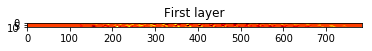

In [25]:
plt.title("First layer")
plt.imshow(W1, cmap='hot')
plt.show()

#### As we can see zero weights on the first layer have those pixels that don't have valuable information about digit (those pixels, that are the same at all images, such as pixels close to edges)

#### Test accurracy without regularization = 90.73% (I used 500 epoches)
#### Test accuracy with regularization = 90.38% (I used 500 epoches)
#### As we can see regularization didn't really help, results are practically the same

### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.